# TextRank

Automatic text summarization is the task of producing a concise and fluent summary while preserving key information
content and overall meaning.

1. Extractive Summarization
 - Identifying the important sentences or phrases from the original text and extract only those from the text.

2. Abstractive Summarization
 - Generating new sentences from the original text


3. TextRank: extractive & unsupervised text summarizatoin
 -  Concatenate text -> sentences -> sentence embeddings -> similarity matrix (between vectors) -> graph

### Connect to existence Github repo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/Shared drives/ZWTZWT/LungCancerTreatment/

/content/drive/Shared drives/ZWTZWT/LungCancerTreatment


In [0]:
!git clone https://github.com/vantuan5644/LungCancerTreatment.git

/content/drive/Shared drives/ZWTZWT
Cloning into 'LungCancerTreatment'...
remote: Enumerating objects: 5928, done.
remote: Counting objects: 100% (5928/5928), done.
remote: Compressing objects: 100% (5278/5278), done.
remote: Total 5928 (delta 742), reused 5749 (delta 563), pack-reused 0
Receiving objects: 100% (5928/5928), 22.71 MiB | 8.42 MiB/s, done.
Resolving deltas: 100% (742/742), done.


## TextRank

In [0]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
import re


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Splitting into sentences

In [0]:
data = pd.read_csv('ground_truths/ground_truth.csv')
data.head()
stage_level = data[['text', 'stage_level']].groupby('stage_level').agg({'text': lambda text: ' '.join(text),
                                                                        })
data = stage_level.reset_index(level=0)
data

,stage_level,text
0,0.0,Because stage 0 NSCLC is limited to the lining...
1,1.0,"If you have stage I NSCLC, surgery may be the ..."
2,2.0,People who have stage II NSCLC and are healthy...
3,3.0,Treatment for stage IIIA NSCLC may include som...
4,4.0,Stage IV NSCLC is widespread when it is diagno...


In [0]:
# Split text into sentences
from nltk. tokenize import sent_tokenize
sentences = []
for s in data['text']:
    sentences.append(sent_tokenize(s))

sentences = [y for x in sentences for y in x] # flatten list
sentences[:5]

['Because stage 0 NSCLC is limited to the lining layer of airways and has not invaded deeper into the lung tissue or other areas, it is usually curable by surgery alone.',
 'No chemotherapy or radiation therapy is needed.',
 'If you are healthy enough for surgery, you can usually be treated by segmentectomy or wedge resection (removal of part of the lobe of the lung).',
 'Cancers in some locations (such as where the windpipe divides into the left and right main bronchi) may be treated with a sleeve resection, but in some cases they may be hard to remove completely without removing a lobe (lobectomy) or even an entire lung (pneumonectomy).',
 'For some stage 0 cancers, treatments such as photodynamic therapy (PDT), laser therapy, or brachytherapy (internal radiation) may be alternatives to surgery.']

### Make sentences embeddings from GloVe

In [0]:
# GloVe Embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-04-11 08:49:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-11 08:49:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-11 08:49:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
# Extract word vectors
word_embeddings = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()


#### Text Preprocessing

Remove new-line character

In [0]:
clean_sentences = [re.sub('\n+', ' ', sent) for sent in sentences]


Remove stopwords

In [0]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]


#### Make sentence vectors from word embeddings

In [0]:
sentence_vectors = []
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split()))
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)
  
assert len(sentences) == len(sentence_vectors)

In [0]:
sentence_vectors[0].shape

(100,)

### Similarity Matrix Preparation

In [0]:
# Similarity matrix is a zero matrix with dimension (n, n)
# We will initialize this matrix with cosine similarity of the sentences 
sim_mat = np.zeros([len(sentences), len(sentences)])


In [0]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]


### Applying PageRank algorithm

#### Convert into graph

We need to convert the similarity matrix **sim_mat** into a graph.

The nodes of this graph will represent the sentences and the edges will represent the similarity scores between sentences.

In [0]:
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)


#### Summary Extraction

Extracting the top N sentences based on their rankings for summary generation

In [0]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)


In [0]:
# Extract top 10 sentences as the summary
for i in range(10):
  print(ranked_sentences[i][1])


NSCLC that has spread to only one other site Cancer that is limited in the lungs and has only spread to one other site (such as the brain) is not common, but it can sometimes be treated (and even potentially cured) with surgery and/or radiation therapy to treat the area of cancer spread, followed by treatment of the cancer in the lung.
Even if positive margins are not found, chemo is usually recommended after surgery to try to destroy any cancer cells that might have been left behind.
As with stage I cancers, newer lab tests now being studied may help doctors find out which patients need this adjuvant treatment and which are less likely to benefit from it.
If you are in otherwise good health, treatments such as surgery, chemotherapy (chemo), targeted therapy, immunotherapy, and radiation therapy may help you live longer and make you feel better by relieving symptoms, even though they aren’t likely to cure you.
For people with stage I NSCLC that has a higher risk of coming back (based o

# Sequence-to-Sequence Modeling

There are two major components of a Seq2Seq model:

- Encoder: An LSTM model reads the entire input sequence wherein, at each timestep, one word is fed into the encoder. It then processes the information at every timestep and captures the contextual information present in the input sequence.

![LSTM Encoder](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/05/61.jpg)


- Decoder: An LSTM network which reads the entire target sequence word-by-word and predicts the same sequence offset by one timestep. **The decoder is trained to predict the next word in the sequence given the previous word.**

![LSTM Decoder](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/05/71.jpg)


The encoder converts the entire input sequence into a fixed length vector and then the decoder predicts the output sequence. Hence it is difficult for the encoder to memorize long sequences into a fixed length vector. We can overcome this issue by using **attention mechanism**, that aims to predict a word by looking at a few specific parts of the sequence only, rather than the entire sequence.


### Train on AmazonFineFoodReview Dataset

This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories.



In [3]:
import numpy as np  
import pandas as pd 
import re           
import os
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


Using TensorFlow backend.


In [4]:
%cd src/text_summarization/

/content/drive/Shared drives/ZWTZWT/LungCancerTreatment/src/text_summarization


In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vantuan5644","key":"e42b59d4233ccff575f11002cc6e0c90"}'}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [8]:
import os
os.getcwd()


'/content/drive/Shared drives/ZWTZWT/LungCancerTreatment'

In [0]:
!kaggle datasets list -s amazon


ref                                                  title                                               size  lastUpdated          downloadCount  
---------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
snap/amazon-fine-food-reviews                        Amazon Fine Food Reviews                           242MB  2017-05-01 18:51:31          67526  
sid321axn/amazon-alexa-reviews                       Amazon Alexa Reviews                               164KB  2018-07-31 17:45:14           7724  
bittlingmayer/amazonreviews                          Amazon Reviews for Sentiment Analysis              493MB  2019-11-18 02:50:34          23275  
grikomsn/amazon-cell-phones-reviews                  Amazon Cell Phones Reviews                           9MB  2019-12-26 22:21:16           6143  
datafiniti/consumer-reviews-of-amazon-products       Consumer Reviews of Amazon Products                 16MB  2

In [0]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

100% 241M/242M [00:03<00:00, 67.4MB/s]
100% 242M/242M [00:03<00:00, 71.9MB/s]


In [0]:
os.listdir(os.getcwd())

['__init__.py',
 'extractive_textrank.ipynb',
 'sentences_transformer.py',
 'attention.py',
 '.ipynb_checkpoints',
 '__pycache__',
 'kaggle.json',
 'amazon-fine-food-reviews.zip']

In [0]:
dataset_file = os.getcwd() + '/amazon-fine-food-reviews.zip'
import zipfile
zip_ref = zipfile.ZipFile(dataset_file, 'r') 
zip_ref.extractall()
zip_ref.close()


In [0]:
os.listdir(os.getcwd())

['__init__.py',
 'extractive_textrank.ipynb',
 'sentences_transformer.py',
 'attention.py',
 '.ipynb_checkpoints',
 '__pycache__',
 'kaggle.json',
 'amazon-fine-food-reviews.zip',
 'Reviews.csv',
 'database.sqlite',
 'hashes.txt']

### Load the dataset

In [0]:
data = pd.read_csv("Reviews.csv")


In [6]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


Drop duplicates and NA values

In [0]:
data.drop_duplicates(subset=['Text'], inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

In [0]:
from contraction import contraction_mapping

#### Text cleaning
 - Convert to lowercase
 - Remove HTML tags
 - Contraction mapping
 - Remove special characters
 - Remove stopwords


In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text, remove_short_words=False, remove_xml_tag=False):
    newString = text.lower()
    if remove_xml_tag:
      newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub('\n+', ' ', newString)
    newString = re.sub("[^a-zA-Z0-9]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    if remove_short_words:
      long_words=[]
      for i in tokens:
          if len(i) >= 3:                  # removing short word
              long_words.append(i)   
      return (" ".join(long_words)).strip()
    else:
      return ' '.join(tokens)


In [0]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t, remove_xml_tag=True))


In [0]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t, remove_xml_tag=False))


In [0]:
data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)


#### Load cleaned data

In [0]:
# data[['cleaned_text', 'cleaned_summary']].to_csv('amazon_fine_food_review_cleaned', index=False)

In [0]:
data = pd.DataFrame('amazon_fine_food_review_cleaned')

Add the **START** and **END** token to the label (summary)

In [0]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')


texts variable contains all text strings, used for creating embeddings matrix

In [0]:
texts = data['cleaned_text']
texts = texts.append(data['cleaned_summary']).to_list()

In [15]:
len(texts)

785258

#### Padding for mini-batch processing


Visualize text-length distribution

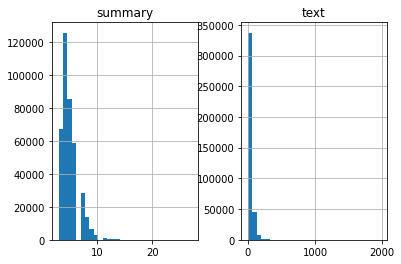

In [18]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()


#### Use pretrained GloVe embedding layer


In [0]:
class GlobalConfigs:
  num_words = 150000
  embeddings_dim = 300
  project_root_dir = '/content/drive/Shared drives/ZWTZWT/LungCancerTreatment/'
  max_len_text = 80
  max_len_summary = 10
  start_token = '_START_ '
  end_token =  ' _END_'
  unknown_emb = np.random.rand(1, embeddings_dim)
  model_path = os.path.join(project_root_dir, 'src', 'text_summarization', 'models', 'weights.h5')

In [0]:
# Preparing GloVe
embeddings_index = {}
f = open(os.path.join(GlobalConfigs.project_root_dir, 'glove.6B.{}d.txt'.format(GlobalConfigs.embeddings_dim)))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


Make embeddings matrix

In [0]:
tokenizer = Tokenizer(num_words=GlobalConfigs.num_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)


In [22]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 136944 unique tokens.


In [0]:
def get_embeddings_matrix(embeddings_dimension, embeddings_index):
  embedding_matrix = np.zeros((len(word_index) + 1, embeddings_dimension))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
  return embedding_matrix


In [0]:
def get_embedding_layer(max_input_length, layer_name):
  layer = Embedding(len(tokenizer.word_index) + 1, GlobalConfigs.embeddings_dim,
                    weights=[get_embeddings_matrix(GlobalConfigs.embeddings_dim, embeddings_index)],
                    input_length=max_input_length, trainable=False,  name=layer_name)
  return layer

#### Index2Word & Word2Index

In [0]:
from collections import Counter


In [0]:
def fit_text(X, Y, input_seq_max_length=None, target_seq_max_length=None):
    if input_seq_max_length is None:
        input_seq_max_length = GlobalConfigs.max_len_text
    if target_seq_max_length is None:
        target_seq_max_length = GlobalConfigs.max_len_summary
    input_counter = Counter()
    target_counter = Counter()
    max_input_seq_length = 0
    max_target_seq_length = 0

    for line in X:
        text = [word.lower() for word in line.split(' ')]
        seq_length = len(text)
        if seq_length > input_seq_max_length:
            text = text[0:input_seq_max_length]
            seq_length = len(text)
        for word in text:
            input_counter[word] += 1
        max_input_seq_length = max(max_input_seq_length, seq_length)

    for line in Y:
        line2 = 'START ' + line.lower() + ' END'
        text = [word for word in line2.split(' ')]
        seq_length = len(text)
        if seq_length > target_seq_max_length:
            text = text[0:target_seq_max_length]
            seq_length = len(text)
        for word in text:
            target_counter[word] += 1
            max_target_seq_length = max(max_target_seq_length, seq_length)

    input_word2idx = dict()
    for idx, word in enumerate(input_counter.most_common(GlobalConfigs.num_words)):
        input_word2idx[word[0]] = idx + 2
    input_word2idx['PAD'] = 0
    input_word2idx['UNK'] = 1
    input_idx2word = dict([(idx, word) for word, idx in input_word2idx.items()])

    target_word2idx = dict()
    for idx, word in enumerate(target_counter.most_common(GlobalConfigs.num_words)):
        target_word2idx[word[0]] = idx + 1
    target_word2idx['UNK'] = 0

    target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])
    
    num_input_tokens = len(input_word2idx)
    num_target_tokens = len(target_word2idx)

    config = dict()
    config['input_word2idx'] = input_word2idx
    config['input_idx2word'] = input_idx2word
    config['target_word2idx'] = target_word2idx
    config['target_idx2word'] = target_idx2word
    config['num_input_tokens'] = num_input_tokens
    config['num_target_tokens'] = num_target_tokens
    config['max_input_seq_length'] = max_input_seq_length
    config['max_target_seq_length'] = max_target_seq_length

    return config

### Custom Attention Layer

In [0]:
from attention import AttentionLayer

### Attention Model

In [0]:
def seq2seq_attention_model(hidden_dim, embedding_dim, max_len_encoder, max_len_decoder):
  # Encoder
  encoder_inputs = Input(shape=(max_len_encoder,))

  # embedding layer
  enc_emb =  get_embedding_layer(max_len_encoder, layer_name='emb_encoder')(encoder_inputs)

  # encoder lstm 1
  encoder_lstm1 = LSTM(hidden_dim, return_sequences=True, return_state=True)
  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

  # encoder lstm 2
  encoder_lstm2 = LSTM(hidden_dim, return_sequences=True, return_state=True)
  encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output1)

  # Set up the decoder. 
  decoder_inputs = Input(shape=(None,)) 
  dec_emb_layer = get_embedding_layer(max_len_decoder, layer_name='emb_decoder')
  dec_emb = dec_emb_layer(decoder_inputs) 

  # LSTM using encoder_states as initial state
  decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True) 
  decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

  # Attention Layer
  attn_layer = AttentionLayer(name='attention_layer') 
  attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

  # Concat attention output and decoder LSTM output 
  decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

  # Dense layer
  decoder_dense = TimeDistributed(Dense(max_len_decoder, activation='softmax')) 
  decoder_outputs = decoder_dense(decoder_concat_input) 

  # Define the model
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
  return model



In [29]:
model = seq2seq_attention_model(hidden_dim=300, embedding_dim=GlobalConfigs.embeddings_dim,
                                max_len_encoder=GlobalConfigs.max_len_text,
                                max_len_decoder=GlobalConfigs.max_len_summary)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
emb_encoder (Embedding)         (None, 80, 300)      41083500    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 300), (N 721200      emb_encoder[0][0]                
______________________________________________________________________________________________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])


### Data loader

In [0]:
config = fit_text(data['cleaned_text'], data['cleaned_summary'])


In [0]:
class Seq2SeqGloVeSummarizer:
  def __init__(self, config, model):
    self.max_input_seq_length = config['max_input_seq_length']
    self.num_target_tokens = config['num_target_tokens']
    self.max_target_seq_length = config['max_target_seq_length']
    self.target_word2idx = config['target_word2idx']
    self.target_idx2word = config['target_idx2word']
    self.version = 0
    if 'version' in config:
      self.version = config['version']

    self.word2em = dict()
    if 'unknown_emb' in config:
      self.unknown_emb = config['unknown_emb']
    else:
      self.unknown_emb = GlobalConfigs.unknown_emb
      config['unknown_emb'] = self.unknown_emb

    self.config = config
    self.model = model

  def transform_input_text(self, texts):
    temp = []
    for line in texts:
        x = np.zeros(shape=(self.max_input_seq_length, GlobalConfigs.embeddings_dim))
        for idx, word in enumerate(line.lower().split(' ')):
            if idx >= self.max_input_seq_length:
                break
            emb = self.unknown_emb
            if word in self.word2em:
                emb = self.word2em[word]
            x[idx, :] = emb
        temp.append(x)
    temp = pad_sequences(temp, maxlen=self.max_input_seq_length)

    print(temp.shape)
    return temp

  def transform_target_encoding(self, texts):
    temp = []
    for line in texts:
        x = []
        for word in line.split(' '):
            x.append(word)
            if len(x) >= self.max_target_seq_length:
                break
        temp.append(x)

    temp = np.array(temp)
    print(temp.shape)
    return temp

  def generate_batch(self, x_samples, y_samples, batch_size):
    num_batches = len(x_samples) // batch_size
    while True:
      for batchIdx in range(0, num_batches):
        start = batchIdx * batch_size
        end = (batchIdx + 1) * batch_size
        encoder_input_data_batch = pad_sequences(x_samples[start:end], self.max_input_seq_length)
        decoder_target_data_batch = np.zeros(shape=(batch_size, self.max_target_seq_length, self.num_target_tokens))
        decoder_input_data_batch = np.zeros(shape=(batch_size, self.max_target_seq_length, GlobalConfigs.embeddings_dim))
        for lineIdx, target_words in enumerate(y_samples[start:end]):
          for idx, w in enumerate(target_words):
            w2idx = 0  # default [UNK]
            if w in self.word2em:
              emb = self.unknown_emb
              decoder_input_data_batch[lineIdx, idx, :] = emb
            if w in self.target_word2idx:
              w2idx = self.target_word2idx[w]
            if w2idx != 0:
              if idx > 0:
                decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
          yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch

  def fit(self, Xtrain, Ytrain, Xtest, Ytest, epochs=20, batch_size=32, model_path=GlobalConfigs.model_path):

      Ytrain = self.transform_target_encoding(Ytrain)
      Ytest = self.transform_target_encoding(Ytest)

      Xtrain = self.transform_input_text(Xtrain)
      Xtest = self.transform_input_text(Xtest)

      train_gen = self.generate_batch(Xtrain, Ytrain, batch_size)
      test_gen = self.generate_batch(Xtest, Ytest, batch_size)

      train_num_batches = len(Xtrain) // batch_size
      test_num_batches = len(Xtest) // batch_size

      history = self.model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                                          epochs=epochs,
                                          verbose=VERBOSE, validation_data=test_gen, validation_steps=test_num_batches,
                                          callbacks=[checkpoint])
      self.model.save_weights(model_path)
      return history

  def summarize(self, input_text):
        input_seq = np.zeros(shape=(1, self.max_input_seq_length, GlobalConfigs.embeddings_dim))
        for idx, word in enumerate(input_text.lower().split(' ')):
            if idx >= self.max_input_seq_length:
                break
            emb = self.unknown_emb  # default [UNK]
            if word in self.word2em:
                emb = self.word2em[word]
            input_seq[0, idx, :] = emb
        states_value = self.encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, GlobalConfigs.embeddings_dim))
        target_seq[0, 0, :] = self.word2em['start']
        target_text = ''
        target_text_len = 0
        terminated = False
        while not terminated:
            output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value)

            sample_token_idx = np.argmax(output_tokens[0, -1, :])
            sample_word = self.target_idx2word[sample_token_idx]
            target_text_len += 1

            if sample_word != 'start' and sample_word != 'end':
                target_text += ' ' + sample_word

            if sample_word == 'end' or target_text_len >= self.max_target_seq_length:
                terminated = True

            if sample_word in self.word2em:
                target_seq[0, 0, :] = self.word2em[sample_word]
            else:
                target_seq[0, 0, :] = self.unknown_emb

            states_value = [h, c]
        return target_text.strip()


### Model training

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['cleaned_summary'],
                                                    test_size=0.1, random_state=0, shuffle=True) 


In [0]:
summarizer = Seq2SeqGloVeSummarizer(config, model)


In [0]:
history = summarizer.fit(X_train, y_train, X_test, y_test, epochs=20, batch_size=4)


(353366,)
(39263,)
